## Assignment 4 
### April 28 2021
### Meenu Ravi

### Part 1. 10 pts - Exploratory Data Analysis

#### 1) 10 pts Complete a quantitative and qualitative data exploration. Include a verbal summary of your EDA.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sktime.forecasting.all import temporal_train_test_split
from statsmodels.tsa.stattools import kpss, adfuller
import warnings
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import math
from sktime.performance_metrics.forecasting import smape_loss
from sktime.performance_metrics.forecasting import mape_loss
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv("hw4_data.csv")
data

,ds,co2
0,1958-03-15,315.700
1,1958-04-15,317.450
2,1958-05-15,317.510
3,1958-06-15,316.685
4,1958-07-15,315.860
...,...,...
730,2019-01-15,410.920
731,2019-02-15,411.660
732,2019-03-15,412.000
733,2019-04-15,413.510


In [3]:
data.shape

(735, 2)

In [4]:
missing_values=data['co2'].isna().sum()
full=len(data)
percent=(missing_values/full)*100
percent

0.0

In [5]:
data.describe()

,co2
count,735.000000
mean,354.210673
std,27.922811
min,313.200000
25%,328.785000
50%,351.340000
75%,376.515000
max,414.830000


In [6]:
data.dtypes

ds      object
co2    float64
dtype: object

In [7]:
duplicate_rows = data[data.duplicated()]
print("Duplicate rows: ", duplicate_rows.shape)

Duplicate rows:  (0, 2)


(array([], dtype=int64),)


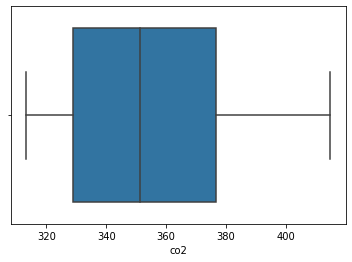

In [8]:
sns.boxplot(x=data['co2'])
print(np.where(data['co2']>data['co2'].quantile(0.75) + (1.5 * (data['co2'].quantile(0.75)-
                                                                  data['co2'].quantile(0.25)))))

<AxesSubplot:>

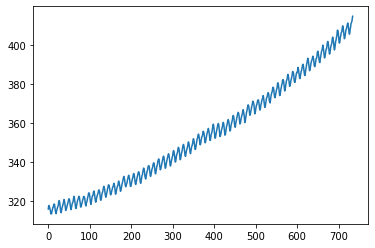

In [9]:
data['co2'].plot()

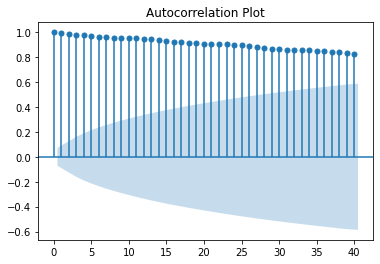

In [10]:
p=plot_acf(data['co2'], lags=40,title='Autocorrelation Plot')

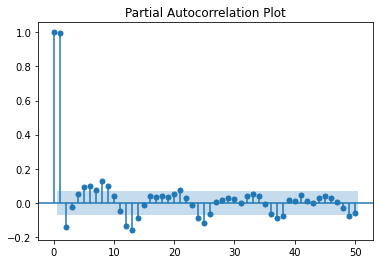

In [11]:
p = plot_pacf(data['co2'],lags=50,  title='Partial Autocorrelation Plot')

In [12]:
data['ds']

0      1958-03-15
1      1958-04-15
2      1958-05-15
3      1958-06-15
4      1958-07-15
          ...    
730    2019-01-15
731    2019-02-15
732    2019-03-15
733    2019-04-15
734    2019-05-15
Name: ds, Length: 735, dtype: object

In [13]:
def adf_kpss_test(timeseries,trend='c'):
    #Perform Dickey-Fuller test:
    df_results=[]
    kpss_results=[]
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print("---------------")
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    for i in dfoutput:
        i=round(i,6)
        df_results.append(i)
    for i in kpss_output:
        i=round(i,6)
        kpss_results.append(i)
    return (df_results,kpss_results)

In [14]:
alpha = 0.05
ad_fuller_results,kpss_test_results = adf_kpss_test(data['co2'], trend='ct')
ad_fuller_results
ad_fuller_pval = ad_fuller_results[1]
ad_fuller_bool = ad_fuller_pval <= alpha

print(f'stationarity from ad_fuller test: {ad_fuller_bool}')

kpss_pval = kpss_test_results[1]
kpss_test_bool = kpss_pval >= alpha

print(f'stationarity from KPSS test: {kpss_test_bool}')

Results of Dickey-Fuller Test:
Test Statistic                   5.242612
p-value                          1.000000
#Lags Used                      20.000000
Number of Observations Used    714.000000
Critical Value (1%)             -3.439542
Critical Value (5%)             -2.865596
Critical Value (10%)            -2.568930
dtype: float64
---------------
Results of KPSS Test:
Test Statistic            0.812704
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
stationarity from ad_fuller test: False
stationarity from KPSS test: False


I performed qualitative and quantitative EDA on this data. I started by just looking at the dimensions and seeing the data types present in this dataset. I saw that the first column was dates and the second column was the co2 level stored as floats. The co2 levels ranged from  to 313 to 414. I found this range of 100 using the describe function to look at some statistics. In the total 735 rows, I found that there were no missing values or duplicates. Next, I plotted the co2 levels and found that from 1958 to 2019, the co2 increases seasonally. From looking at the graph, I could easily tell there was no stationarity because the mean and variance were not stable. I still performed the adf and kpss tests to ensure my prediction.

### Part 2. 30 pts – Seasonal ARIMA – need to use statsmodels in order to examine residuals

#### A. 6 pts Determine the seasonal differencing order, use y_train. Include the following: plot of differenced data, ADF results, kpss results

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.datasets import load_airline
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

In [16]:
data_monthly=data.copy()
data_monthly['ds'] =data['ds'].astype('datetime64[ns]')
data_monthly

,ds,co2
0,1958-03-15,315.700
1,1958-04-15,317.450
2,1958-05-15,317.510
3,1958-06-15,316.685
4,1958-07-15,315.860
...,...,...
730,2019-01-15,410.920
731,2019-02-15,411.660
732,2019-03-15,412.000
733,2019-04-15,413.510


In [17]:
data_monthly['ds'] = data_monthly['ds'].dt.strftime('%Y-%m')
data_monthly
# data_monthly.dtypes

,ds,co2
0,1958-03,315.700
1,1958-04,317.450
2,1958-05,317.510
3,1958-06,316.685
4,1958-07,315.860
...,...,...
730,2019-01,410.920
731,2019-02,411.660
732,2019-03,412.000
733,2019-04,413.510


In [18]:
data_series=data_monthly['co2']
data_series.index=pd.core.indexes.period.PeriodIndex(data_monthly['ds'].tolist(),freq='m')
data_series

1958-03    315.700
1958-04    317.450
1958-05    317.510
1958-06    316.685
1958-07    315.860
            ...   
2019-01    410.920
2019-02    411.660
2019-03    412.000
2019-04    413.510
2019-05    414.830
Freq: M, Name: co2, Length: 735, dtype: float64

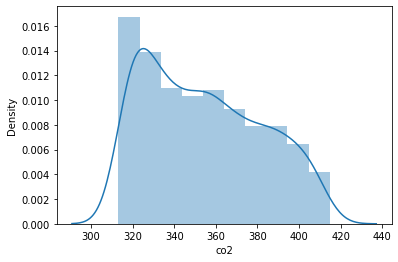

In [22]:
sns.distplot(data_series)
plt.show()

In [19]:
bctransformer = boxcox.BoxCoxTransformer()
data_trans = bctransformer.fit_transform(data_series)
data_trans

1958-03    0.489569
1958-04    0.489569
1958-05    0.489569
1958-06    0.489569
1958-07    0.489569
             ...   
2019-01    0.489571
2019-02    0.489571
2019-03    0.489571
2019-04    0.489571
2019-05    0.489571
Freq: M, Length: 735, dtype: float64

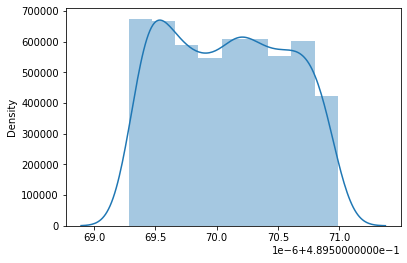

In [23]:
sns.distplot(data_trans)
plt.show()

In [20]:
bctransformer.lambda_

-2.042595516471125

I found lamda and since it was -2 and not close to 1 I decided to keep the box cox transformation

In [21]:
y_train, y_test = temporal_train_test_split(data_trans)

In [22]:
print(y_train.shape)
print(y_test.shape)

(551,)
(184,)


In [23]:
alpha = 0.05
ad_fuller_results,kpss_test_results = adf_kpss_test(y_train, trend='ct')
ad_fuller_results
ad_fuller_pval = ad_fuller_results[1]
ad_fuller_bool = ad_fuller_pval <= alpha

print(f'stationarity from ad_fuller test: {ad_fuller_bool}')

kpss_pval = kpss_test_results[1]
kpss_test_bool = kpss_pval >= alpha

print(f'stationarity from KPSS test: {kpss_test_bool}')

Results of Dickey-Fuller Test:
Test Statistic                   1.321806
p-value                          0.996728
#Lags Used                      13.000000
Number of Observations Used    537.000000
Critical Value (1%)             -3.442586
Critical Value (5%)             -2.866937
Critical Value (10%)            -2.569645
dtype: float64
---------------
Results of KPSS Test:
Test Statistic            0.369043
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
stationarity from ad_fuller test: False
stationarity from KPSS test: False


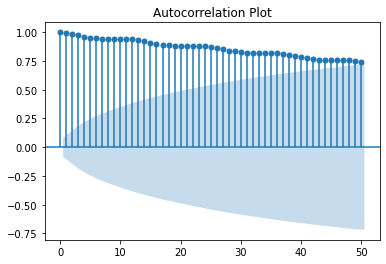

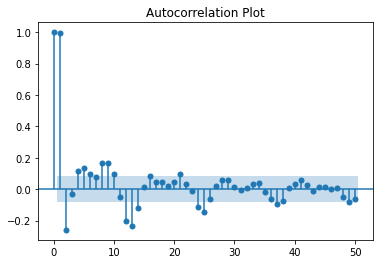

In [24]:
p = plot_acf(y_train,lags=50, title='Autocorrelation Plot')
p = plot_pacf(y_train,lags=50, title='Autocorrelation Plot')

In [25]:
y_train_seasdiff = data_series.diff(12).dropna()
y_train_seasdiff

1959-03    0.950
1959-04    0.270
1959-05    0.780
1959-06    1.465
1959-07    0.680
           ...  
2019-01    2.870
2019-02    3.320
2019-03    2.750
2019-04    3.210
2019-05    3.530
Freq: M, Name: co2, Length: 723, dtype: float64

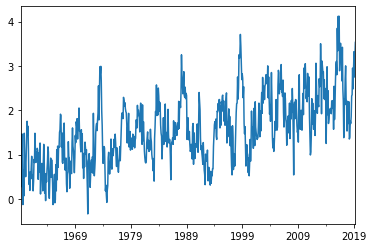

In [26]:
y_train_seasdiff.plot()
plt.show()

In [27]:
alpha = 0.05
ad_fuller_results,kpss_test_results = adf_kpss_test(y_train_seasdiff, trend='ct')
ad_fuller_results
ad_fuller_pval = ad_fuller_results[1]
ad_fuller_bool = ad_fuller_pval <= alpha

print(f'stationarity from ad_fuller test: {ad_fuller_bool}')

kpss_pval = kpss_test_results[1]
kpss_test_bool = kpss_pval >= alpha

print(f'stationarity from KPSS test: {kpss_test_bool}')

Results of Dickey-Fuller Test:
Test Statistic                  -3.694069
p-value                          0.004197
#Lags Used                      13.000000
Number of Observations Used    709.000000
Critical Value (1%)             -3.439607
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
dtype: float64
---------------
Results of KPSS Test:
Test Statistic            0.051203
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
stationarity from ad_fuller test: True
stationarity from KPSS test: True


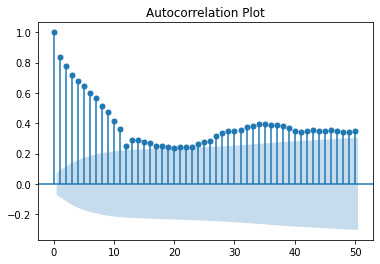

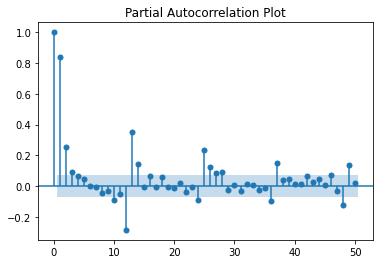

In [28]:
p = plot_acf(y_train_seasdiff,lags=50, title='Autocorrelation Plot')
p = plot_pacf(y_train_seasdiff,lags=50, title='Partial Autocorrelation Plot')

I decided to use 2,1,0,12 as the seasonal order

#### B. 6 pts Determine the non-seasonal differencing order, use the seasonally differenced training time series. Include the following: plot of differenced data, ADF results, kpss results, ACF and PACF

I decided to nonseasonally difference once because our data still wasn't stationary after doing a seasonal difference

In [29]:
y_train_nonseas_diff = y_train_seasdiff.diff().dropna()
y_train_nonseas_diff

1959-04   -0.680
1959-05    0.510
1959-06    0.685
1959-07   -0.785
1959-08   -0.810
           ...  
2019-01    0.390
2019-02    0.450
2019-03   -0.570
2019-04    0.460
2019-05    0.320
Freq: M, Name: co2, Length: 722, dtype: float64

<AxesSubplot:>

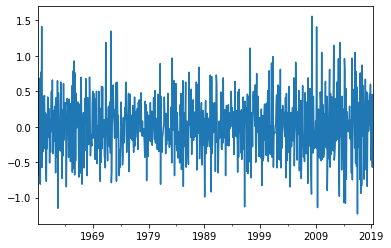

In [30]:
y_train_nonseas_diff.plot()

In [31]:
alpha = 0.05
ad_fuller_results,kpss_test_results = adf_kpss_test(y_train_nonseas_diff, trend='ct')
ad_fuller_results
ad_fuller_pval = ad_fuller_results[1]
ad_fuller_bool = ad_fuller_pval <= alpha

print(f'stationarity from ad_fuller test: {ad_fuller_bool}')

kpss_pval = kpss_test_results[1]
kpss_test_bool = kpss_pval >= alpha

print(f'stationarity from KPSS test: {kpss_test_bool}')

Results of Dickey-Fuller Test:
Test Statistic                -9.575398e+00
p-value                        2.230438e-16
#Lags Used                     1.600000e+01
Number of Observations Used    7.050000e+02
Critical Value (1%)           -3.439660e+00
Critical Value (5%)           -2.865648e+00
Critical Value (10%)          -2.568958e+00
dtype: float64
---------------
Results of KPSS Test:
Test Statistic            0.015703
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
stationarity from ad_fuller test: True
stationarity from KPSS test: True


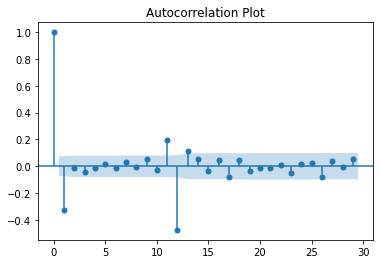

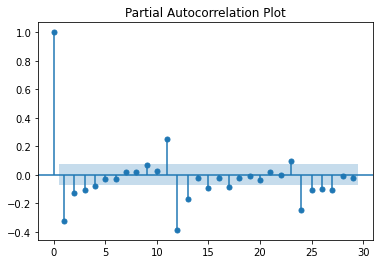

In [32]:
p = plot_acf(y_train_nonseas_diff, title='Autocorrelation Plot')
p = plot_pacf(y_train_nonseas_diff, title='Partial Autocorrelation Plot')

I decided to use 1,1,1 as the non seasonal order

#### C) 6 pts Fit and predict a SARIMA model using your best estimate of the SARIMA(p,d,q)(P,D,Q)m order. Return the model summary

In [33]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(1,1,1), seasonal_order=(2, 1, 0, 12))
sarima_fit = sarima_model.fit()
y_pred_train=sarima_fit.forecast(steps = len(y_train))
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  551
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                5222.000
Date:                             Wed, 28 Apr 2021   AIC                         -10433.999
Time:                                     08:47:43   BIC                         -10412.560
Sample:                                 03-31-1958   HQIC                        -10425.613
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0687    2.3e-20  -2.98e+18      0.000      -0.069      -0.069
ma.L1         -0.2886   2.6

#### D) 6 pts Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results

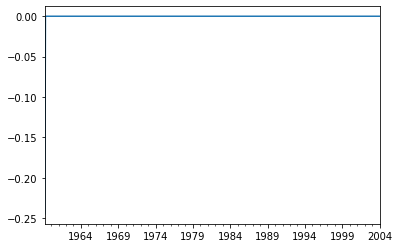

In [34]:
resid = sarima_fit.resid
resid=resid[12:]
resid.plot()
plt.show()

I removed the first 12 from  the residuals because we did a seasonal differencing

I see that there is one outlier here, I removed the outlier so I could better see the residual plot:

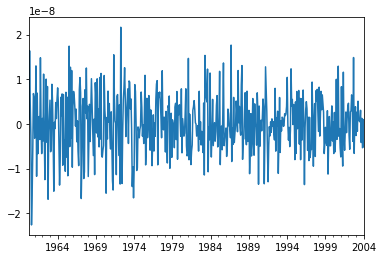

In [35]:
resid_plot=resid[13:]
resid_plot.plot()
plt.show()

<AxesSubplot:>

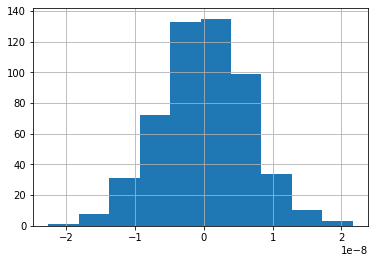

In [36]:
resid_plot.hist()

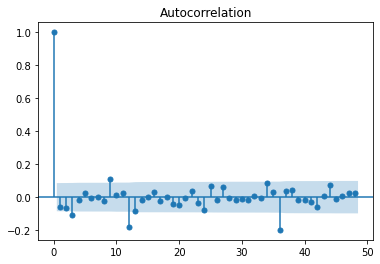

In [37]:
plot_acf(resid_plot, lags=48)
plt.show()

In [38]:
sm.stats.acorr_ljungbox(resid_plot, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,18.053828,0.054062,17.813785,0.058187


To validate our model, we can look the model residuals. The residuals are the difference between the actual data and the predicted value from the sarima model. Based on the visuals above, they are performing as residuals should. 

Plot

The plot of the residuals look like white noise. This way, I can be sure that none of the signal has escaped my model fit and has ended up in the residuals by mistake. 

Histogram

The residuals should also be normally distributed. My histagram shows a normally distributed model. You can see the mean is centered around 0. A normally distributed residuals describes the actual distribution of the random errors in actuality reasonably well. 

ACF
The residuals should not show a trend or autocorrelation, because then we have failed to capture it in our model instead. The residuals should be stationary. In the ACF plot, I can see there isn't took much autocorrelation. There is however, a spike at the lag 1. This shows there is slight autocorrelation there.

Ljung Box

I also performed the Ljung box test (portmanteau). The p-value of the test is 0.053, which is slightly above 0.05. Therefore, we accept the null hypothesis of the test and conclude that the residuals are slightly autocorrelated. Residuals are slight correlation and does show a slight lack of fit. Therefore, we can say that the model is not as good


#### E) 6 pts Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

Here, I reverse the boxcox transformation from the predications and the the test and train so that  we can get back to the original dataset scale and be able to compare statistics much more easily

In [39]:
y_pred=sarima_fit.forecast(steps = len(y_test))

In [40]:
from scipy.special import boxcox, inv_boxcox
y_pred_inv=inv_boxcox(y_pred, -2.042595516471125)
y_pred_inv

2004-02    377.761503
2004-03    378.290358
2004-04    379.594640
2004-05    380.499336
2004-06    380.132728
              ...    
2019-01    414.598144
2019-02    415.824166
2019-03    416.502495
2019-04    418.383691
2019-05    419.477201
Freq: M, Name: predicted_mean, Length: 184, dtype: float64

In [41]:
y_train_inv=inv_boxcox(y_train, -2.042595516471125)
y_train_inv

1958-03    315.700
1958-04    317.450
1958-05    317.510
1958-06    316.685
1958-07    315.860
            ...   
2003-09    372.980
2003-10    373.000
2003-11    374.350
2003-12    375.690
2004-01    376.790
Freq: M, Length: 551, dtype: float64

In [42]:
y_test_inv=inv_boxcox(y_test, -2.042595516471125)
y_test_inv

2004-02    377.37
2004-03    378.39
2004-04    380.50
2004-05    380.62
2004-06    379.55
            ...  
2019-01    410.92
2019-02    411.66
2019-03    412.00
2019-04    413.51
2019-05    414.83
Freq: M, Length: 184, dtype: float64

<AxesSubplot:>

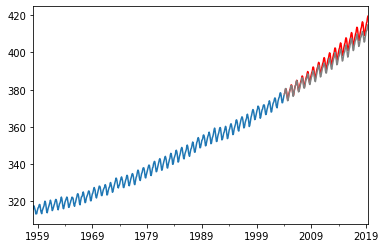

In [43]:
y_train_inv.plot()
y_pred_inv.plot(color='red')
y_test_inv.plot(color = 'grey')

In [44]:
def MASE(training_series, testing_series, prediction_series):
   
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d


In [45]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
smape = smape_loss(y_test_inv, y_pred_inv)
mape = mape_loss(y_test_inv, y_pred_inv)
mase= MASE(y_train_inv, y_test_inv, y_pred_inv)

In [46]:
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'SMAPE: {smape}')
print(f'MAPE: {mape}')
print(f'MASE: {mase}')

Mean Squared Error: 6.577377785647049
Root Mean Squared Error: 2.5646398939514
Mean Absolute Error: 2.200328209848641
SMAPE: 0.005501970402684087
MAPE: 0.00552226654094742
MASE: 2.0441893134445137


### Part 3. 30 pts – Auto ARIMA – need to use pmdarima in order to examine residuals

#### A. 6 pts Fit using auto_arima(), you may need to provide the differencing orders.

In [47]:
y_train, y_test = temporal_train_test_split(data_series)

In [48]:
from pmdarima import auto_arima
am=auto_arima(y_train, seasonal=True,start_p=0,d=1,start_q=0,
          start_P=0,m=12,
          D=1, start_Q=0,suppress_warnings=True)
am.fit(y_train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

#### B. 6 pts Return the model summary

In [49]:
am.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  551
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -111.667
Date:                            Wed, 28 Apr 2021   AIC                            233.335
Time:                                    08:49:02   BIC                            254.774
Sample:                                         0   HQIC                           241.721
                                            - 551                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      1.784      0.074      -0.000       0.004
ar.L1          0.2042      0.111      1.844      0.065      -0.013       0.421
ma.L1         -0.5415      0.099     -5.470      0.000      -0.735      -0.347
ma.S.L12      -0.8647      0.025    -34.889      0.000      -0.913      -0.816
sigma2         0.0860      0.005     16.185      0.000       0.076       0.096
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.83   Prob(JB):                         0.88
Heteroskedasticity (H):               0.83   Skew:                            -0.05
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### C. 6 pts Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results

In [50]:
residuals=pd.Series(am.resid())
residuals=residuals[12:]

I remove the first 12 because we did a seasonal differencing in the auto arima function

<AxesSubplot:>

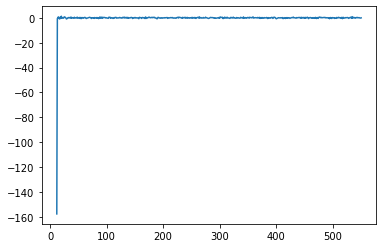

In [51]:
residuals.plot()

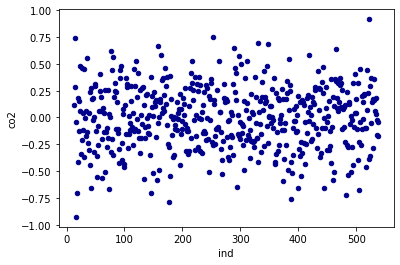

In [52]:
resid_df=pd.DataFrame()
resid_df['ind']=range(0,len(residuals))
resid_df['co2']=residuals.values
resid_df=resid_df[13:]
ax1 = resid_df.plot.scatter(x='ind',
                      y='co2',
                      c='DarkBlue')


Here again, I tried to show the show more clearly after removing an outliers that resulted from the non seasonal differencing. To clearly show the random noise

<AxesSubplot:>

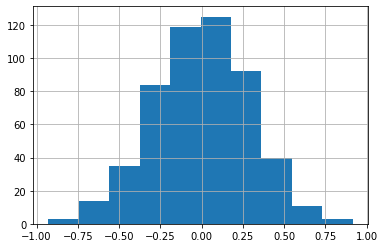

In [53]:
resid_df['co2'].hist()

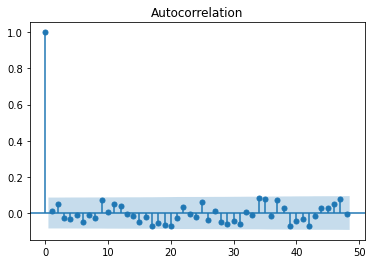

In [54]:
plot_acf(resid_df['co2'], lags=48)
plt.show()

In [55]:
sm.stats.acorr_ljungbox(resid_df['co2'], lags=[15], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
15,10.612407,0.779555,10.401335,0.793765


To validate our model, we can look the model residuals. The residuals are the difference between the actual data and the predicted value from the sarima model. Based on the visuals above, they are performing as residuals should. 

Plot

The plot of the residuals look like white noise. This way, I can be sure that none of the signal has escaped my model fit and has ended up in the residuals by mistake. 

Histogram

The residuals should also be normally distributed. My histagram shows a normally distributed model. You can see the mean is centered around 0. A normally distributed residuals describes the actual distribution of the random errors in actuality reasonably well. 

ACF
The residuals should not show a trend or autocorrelation, because then we have failed to capture it in our model instead. The residuals should be stationary. In the ACF plot, I can see there isn't took much autocorrelation. There isn't any spike as we previously saw. This shows there is no slight autocorrelation there.

Ljung Box

I also performed the Ljung box test (portmanteau). The p-value of the test is 0.8, which is well above 0.05. Therefore, we accept the null hypothesis of the test and conclude that the residuals are not autocorrelated. Residuals are independently distributed  and does not show a lack of fit. Therefore, we can say that the model is good


#### D. 6 pts Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [56]:
y_pred = pd.DataFrame(am.predict(n_periods = len(y_test)),index=y_test.index)
y_pred.columns = ['co2']

In [57]:
y_pred_series=y_pred['co2']
y_pred_series.index=pd.core.indexes.period.PeriodIndex(y_test.index.tolist(),freq='m')
y_pred_series


2004-02    377.642455
2004-03    378.431533
2004-04    379.752289
2004-05    380.352949
2004-06    379.874370
              ...    
2019-01    409.162510
2019-02    410.024225
2019-03    410.841324
2019-04    412.193932
2019-05    412.827225
Freq: M, Name: co2, Length: 184, dtype: float64

<AxesSubplot:>

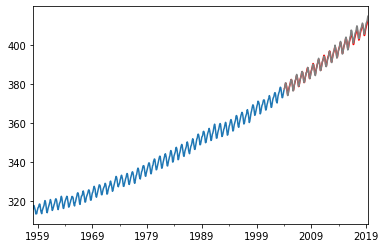

In [58]:
y_train.plot()
y_pred_series.plot(color='red')
y_test.plot(color = 'grey')

In [59]:
def MASE(training_series, testing_series, prediction_series):
   
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d


In [60]:
mae = mean_absolute_error(y_test, y_pred_series)
mse = mean_squared_error(y_test, y_pred_series)
rmse = math.sqrt(mse)
smape = smape_loss(y_test, y_pred_series)
mape = mape_loss(y_test, y_pred_series)
mase= MASE(y_train, y_test, y_pred_series)


In [61]:
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'SMAPE: {smape}')
print(f'MAPE: {mape}')
print(f'MASE: {mase}')

Mean Squared Error: 0.4377980527411992
Root Mean Squared Error: 0.6616630961004242
Mean Absolute Error: 0.49118748746161384
SMAPE: 0.0012340085960326676
MAPE: 0.001233170184061649
MASE: 0.4563320182157184


#### E. 6 pts Summarize the difference between your SARIMA and the Auto Arima models. Compare order, performance on training data, performance on test data. Which model would you go forward with?

Here are the error statistics from Sarima

Mean Squared Error: 6.577377785647049

Root Mean Squared Error: 2.5646398939514

Mean Absolute Error: 2.200328209848641

SMAPE: 0.005501970402684087

MAPE: 0.00552226654094742

MASE: 2.0441893134445137

These are the results from AutoArima

Mean Squared Error: 0.4377980527411992

Root Mean Squared Error: 0.6616630961004242

Mean Absolute Error: 0.49118748746161384

SMAPE: 0.0012340085960326676

MAPE: 0.001233170184061649

MASE: 0.4563320182157184

When comparing the errors, the auto arima seems to be performing much better at every statistics. 
For MSE the smaller the means squared error, the closer you are to finding the line of best fit. The auto arima model seems to be finding closer co2 levels.
When comparing Smape, they are performing similarly but the autoarima tends to be a little bit better at finding more accurate values of co2 levels.


When we comapare the residuals both models performed well. The sarima model actually showed slight correlation when we look at the ACF plots and lb statistics. Also, when we look at the p value for the ljung box test, the autoarima model has a higher p value. This make us more confident that the residuals are independently distributed and the model does not show a lack of fit. 

Finding a proper model to accurately predict and forecast the level of co2 is very important because  co2 is a main cause of global warming. Global Warming and problems associated with it are a significant and detrimental to life of plant and animals. So, to move forward, we would need a highly accurate model.

In order to make accurate forecasts, our choice of model will have to take into consideration both trend and seasonality. From the analysis above, we saw that the co2 data presented to us is not stationary. The trend changes at each point in timeand the seasonality compoent causes cycles that ate increasing through time. This portion should not be included in the residuals, which capture and resemble white noise. The auto arima take into accout a seasonal and non seasonal differencing and the residual analysis ensure that none of the trend or seasonality gets captures.

Since this model performs well, moving forward, we can have more confidence that our forecasts will be accurate. This is important for predicting co2 levels. If we are more accurate, we can estimate better when the co2 level will be dangerous and can prepare for this. Perhaps if we know this, we can build safe environment for animals and prepare greenhouses for plants.

### Part 4. 30 pts plus 20 pts extra credit – Recursive method with best model

#### A. 10 pts Use/modify the rolling fit class to fit and predict with the best model from above. Adjust train size from the sample in RollingFit_for_Assignment4.ipynb. This probably works best w sktime implementation.

Moving forward with autoarima model

In [136]:
from sktime.forecasting.all import AutoARIMA
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.all import temporal_train_test_split

In [135]:
y =pd.read_csv('hw4_data.csv', index_col=0)
y.index = pd.core.indexes.period.PeriodIndex(y.index, freq='m')
y

,co2
ds,
1958-03,315.700
1958-04,317.450
1958-05,317.510
1958-06,316.685
1958-07,315.860
...,...
2019-01,410.920
2019-02,411.660
2019-03,412.000


In [137]:
class RollingFit:
    def __init__(self, y, train_size=551, model=AutoARIMA() ):
        
        self.y = y
        self.model = model
        
        self.train_y, self.test_y = temporal_train_test_split(y, train_size=train_size)
#         print(self.train_y.shape)
        self._test_y = self.test_y
        self.ypred_ = self.train_y
        self.fit()
        
    def fit(self):
        N = len( self.test_y )
#         print(N)
        for i in range(0, N):
#             print(i)
            self.fit_model()
            ypred = self.predict_one()
            self.add_to_predictions( ypred )
            self.move_one_test_to_train()
            self.drop_one_from_test()
    
    
    def fit_model(self):
        y = self.train_y
        self.model.fit( y )
        
    def predict_one(self):
        ypred = self.model.predict(1)
        return ypred
    
    def add_to_predictions(self, ypred):
        self.ypred_ = pd.concat([self.ypred_, ypred])
        
        
    def move_one_test_to_train(self):
        series_to_add = pd.Series( 
            self.test_y[0], 
            index = [ self.test_y.index[0] ] 
        )
        self.train_y = pd.concat( [self.train_y, series_to_add ])    
    
    def drop_one_from_test(self):
        self.test_y = self.test_y[1:]

In [138]:
rolling_fit_model = RollingFit(y['co2'], model=ARIMA((1,1,1), seasonal_order=(0,1,1,12) ))

In [139]:
y_test_set=rolling_fit_model.train_y[551:]
y_pred_set=rolling_fit_model.ypred_[551:]

#### B. *20 pts extra credit* Create your own function or class to perform a different method of recursive forecasting. Can use any other recursive method, here is a paper for inspiration, not limitation: https://arxiv.org/pdf/1108.3259.pdf

The method I chose was to use first a training set and predict the next month's value of co2. Then, use that prediction as a part of the training set and train the model with the new prediction. Then take the resulting prediction and adding it to the trains et and fit the model to the new training set with the predicted values and so on.
After reading the paper above, I saw that one possible method was to used the hybrid model of recursion and prediction so I tried this way below:

In [140]:
class RecursiveForecast:
    def __init__(self, y, train_size=551, model=AutoARIMA() ):
        
        self.y = y
        self.model = model
        self.train_y, self.test_y = temporal_train_test_split(y, train_size=train_size)
        self._test_y = self.test_y
        self.ypred_ = self.train_y
        self.fit()
        
    def fit(self):
        N = len( self.test_y )
        for i in range(0, N):
            self.fit_model()
            ypred = self.predict_one()
            self.add_to_predictions( ypred )
            self.move_one_pred_to_train(ypred)
#             print(self.train_y)
            self.drop_one_from_test()
    
    
    def fit_model(self):
        y = self.train_y
        self.model.fit( y )
        
    def predict_one(self):
        ypred = self.model.predict(1)
        return ypred
    
    def add_to_predictions(self, ypred):
        self.ypred_ = pd.concat([self.ypred_, ypred])
        
        
    def move_one_pred_to_train(self,prediction):
        series_to_add = pd.Series( 
            prediction, 
            index = [ self.test_y.index[0] ] 
        )
        self.train_y = pd.concat( [self.train_y, series_to_add ])    
    
    def drop_one_from_test(self):
        self.test_y = self.test_y[1:]

In [141]:
recursive_model = RecursiveForecast(y['co2'], model=ARIMA((1,1,1), seasonal_order=(0,1,1,12) ))

In [142]:
original_data=pd.Series(y['co2'])
original_data.index.name=None
y_test_set2=original_data[551:]
y_pred_set2=recursive_model.ypred_[551:]

#### C. 10 pts Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

Rolling Method Stats

In [143]:
mae = mean_absolute_error(y_test_set, y_pred_set)
mse = mean_squared_error(y_test_set, y_pred_set)
rmse = math.sqrt(mse)
smape = smape_loss(y_test_set, y_pred_set)
mape = mape_loss(y_test_set, y_pred_set)
mase= MASE(rolling_fit_model.train_y, y_test_set, y_pred_set)

In [144]:
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'SMAPE: {smape}')
print(f'MAPE: {mape}')
print(f'MASE: {mase}')

Mean Squared Error: 0.12701416960617812
Root Mean Squared Error: 0.35639047350648717
Mean Absolute Error: 0.2746876521690032
SMAPE: 0.0006978684049097219
MAPE: 0.0006978306470994643
MASE: 0.24774306266916693


Recursive Method 2 Stats

In [145]:
mae = mean_absolute_error(y_test_set2, y_pred_set2)
mse = mean_squared_error(y_test_set2, y_pred_set2)
rmse = math.sqrt(mse)
smape = smape_loss(y_test_set2, y_pred_set2)
mape = mape_loss(y_test_set2, y_pred_set2)
mase= MASE(original_data, y_test_set2, y_pred_set2)

In [146]:
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'SMAPE: {smape}')
print(f'MAPE: {mape}')
print(f'MASE: {mase}')

Mean Squared Error: 0.4441635088178957
Root Mean Squared Error: 0.6664559316398164
Mean Absolute Error: 0.4935730961434671
SMAPE: 0.001239812725483191
MAPE: 0.00123894712218656
MASE: 0.44515765278904007


#### D. 10 pts Summarize the difference between your Recursive forecasts and your h-step ahead forecasts from SARIMA and Auto ARIMA. Explain the methodologies and the reason that you get different results. What are the advantages and disadvantages of the recursive method.

AutoArima:

Mean Squared Error: 0.4377980527411992

Root Mean Squared Error: 0.6616630961004242

Mean Absolute Error: 0.49118748746161384

SMAPE: 0.0012340085960326676

MAPE: 0.001233170184061649

MASE: 0.4563320182157184

Rolling:

Mean Squared Error: 0.12701416960617812

Root Mean Squared Error: 0.35639047350648717

Mean Absolute Error: 0.2746876521690032

SMAPE: 0.0006978684049097219

MAPE: 0.0006978306470994643

MASE: 0.24774306266916693

When I compare my two different recursive methods, I find that the rolling class one is performing much better than the predicted one. This makes sense because the predicted one is using predictions instead of the actual values to build the model. However, I was still surprised by how well it performed compared to the SARIMA and auto arima. The predicted recursive method(2) performed almost the same as the autarima. The error statistics are very very close to each other.
I thought about why and found that since the recursive method is training multiple times on larger and larger training sets, it is predicting on a a smaller test set each time so it tends to be more accurate. You are considering a larger training size data each iteration.

Comparing the better model from SARIMA and auto arima, we found auto arima to be better. When comparing the two recursive methods, we found the rolling method to be better.
Now, Comaring the two better models, the rolling is still better because in all the error statistics, it performs much better.




The methodology behind the recursive method is that you are doing a brute force method by training a separate model for each point in the future that you want to predict. You are forecasing by feeding in the prediction of the model as a new input and using this result to predict a new output. By continuing this pattern until you have no more test values, you are essentially rolling the predictions forward until your desired date or time period is reached. 

With the Srima and autoarima, you are predicting x amount of time steps in the future and only training the model once.
The reason I get different results and statistics is that my training size in the recursive method increases each iteration. So the last value tends to be closer to the actual value because at the last iteration my training set is essentially the whole dataset except the last value. In the sarima and autoarima, you only training the model once so the values at the end of the dataset tend to be farther from the actual values.

The advantages of the recursive model is that your predictions will be closer to the actual value, this producing lower errors.
Rolling recursive method forecasts allow the model to make adjustments by fitting the model each time along the way rather than letting the predictions be far off. It also allows you to predict more steps in the future. Also, each iteration, the forecast horizon is smaller so the variance isn't disturbed too much. In the sarima and autoarima, you will see higher variance because they use fewer observations in the training set when estimating the model and especially when the forecast horizon is larger, the variance tends to be higher. In the recursive method, it eliminates this issue.

A disadvantage of this recursive methods is that you are training a model each iterating. It is okay if the dataset is smaller or medium sized. However if the dataset is large or you are trying to predict further into the future, you will be traing many many models, which will be computationally intensive and may take a longer time.